In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [9]:
size = 9
fi_path = Path(ROOT_DIR, 'results', 'fi', str(size))
fisg_path = Path(ROOT_DIR, 'results', 'fisg', str(size))
fipg_path = Path(ROOT_DIR, 'results', 'fipg', str(size))

fi_color = 'black'
fisg_color = 'darkorange'
fipg_color = 'forestgreen'



def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [20]:
def process_dir(dir_path, key="reward", w=100, trunc=150000, split_by=None):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            if trunc > info[key].shape[0]:
                print(args)
                print(f"length of misbehaving data: {info[key].shape}")
                
            result = moving_avg(info[key][:trunc], w=w)
            all_results[split_by_tuple][hparams].append(result)
            
        else:
            result = moving_avg(info[key][:trunc], w=w)
            all_results.append(result)
    print(args)
    if split_by is not None:
        for k, v in all_results.items():
            for k1, v1 in v.items():
                all_results[k][k1] = np.array(all_results[k][k1])
        data = all_results
    else:
        data = np.array(all_results)

    
    return data


In [21]:
w = 100
fi_data = process_dir(fi_path, w=w)
fisg_data = process_dir(fisg_path, w=w)
fipg_data = process_dir(fipg_path, w=w)


{'max_episode_steps': 1000, 'device': device(type='cpu'), 'slip_turn': True, 'seed': 2040, 'n_hidden': 100, 'save_model': False, 'discounting': 0.9, 'resample_interval': 20, 'size': 9, 'results_dir': PosixPath('/scratch/taodav/uncertainty/results/fi/9'), 'random_start': True, 'step_size': 0.0001, 'results_fname': '16ab5fbf146867e6d214b15d8916b629_Fri Aug 27 08:41:21 2021.npy', 'slip_prob': 0.1, 'env': 'fi', 'update_weight_interval': 1, 'log_dir': PosixPath('/scratch/taodav/uncertainty/log/fi'), 'total_steps': 300000, 'test_eps': 0.0, 'n_particles': 1000, 'epsilon': 0.1, 'blur_prob': 0.3, 'view_test_ep': False}
{'total_steps': 300000, 'step_size': 0.0001, 'n_particles': 1000, 'update_weight_interval': 1, 'env': 'fisg', 'view_test_ep': False, 'save_model': False, 'n_hidden': 100, 'resample_interval': 20, 'max_episode_steps': 1000, 'log_dir': PosixPath('/scratch/taodav/uncertainty/log/fisg'), 'size': 9, 'slip_turn': True, 'epsilon': 0.1, 'random_start': True, 'results_dir': PosixPath('/sc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
all_data = [('Color only (|o| = 5)', fi_data, fi_color), 
            ('one-hot state obs (|o| = 196 + 5)', fisg_data, fisg_color),
            ('all-state uncertainty obs (|o| = 196 + 5)', fipg_data, fipg_color)
           ]
# all_data = [(f"PF + obs (n = {k[0]})", d, pr_colors[i]) for i, (k, d) in enumerate(pr_uwi_data)]

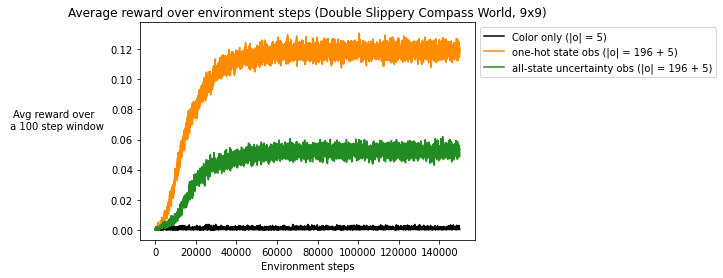

In [23]:
x = np.arange(fi_data.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Avg reward over \n a {w} step window", rotation=0, labelpad=55)
ax.set_title(f'Average reward over environment steps (Double Slippery Compass World, {size}x{size})')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


In [7]:
all_vars = []
trunc = 60000

for info_path in pr_path.iterdir():
    pr_info = load_info(info_path)
    args = pr_info['args'].item()
    
    if args['update_weight_interval'] == 1:
        single_particle_times = []
        all_ending_vars = []
        all_run_vars = []
        for ep, (m_ep, v_ep) in enumerate(zip(pr_info['pf_episodic_mean'][:trunc], pr_info['pf_episodic_var'][:trunc])):
            for step, (m, v) in enumerate(zip(m_ep, v_ep)):
                all_run_vars.append(v.sum())
                if np.isclose(v.sum(), 0):
                    single_particle_times.append((ep, step))
                    break

            all_ending_vars.append((ep, step, v.sum()))
        all_vars.append(np.array(all_run_vars))

NameError: name 'pr_path' is not defined

In [82]:
variances = np.array(all_vars)

/tmp/ipykernel_3045/3233260353.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  variances = np.array(all_vars)


In [91]:
variances[-1].shape, len(all_ending_vars)

((41665,), 4186)